In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_csv('city_hotel.csv')

In [4]:
df.shape

(53399, 34)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53399 entries, 0 to 53398
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     53399 non-null  int64  
 1   lead_time                       53399 non-null  int64  
 2   arrival_date_year               53399 non-null  int64  
 3   arrival_date_month              53399 non-null  object 
 4   arrival_date_week_number        53399 non-null  int64  
 5   arrival_date_day_of_month       53399 non-null  int64  
 6   stays_in_weekend_nights         53399 non-null  int64  
 7   stays_in_week_nights            53399 non-null  int64  
 8   adults                          53399 non-null  int64  
 9   children                        53399 non-null  float64
 10  babies                          53399 non-null  int64  
 11  meal                            53399 non-null  object 
 12  country                         

In [8]:
selected_columns = [
    "adults", "children", "lead_time", "previous_cancellations",
    "previous_bookings_not_canceled", "booking_changes",
    "stays_in_weekend_nights", "stays_in_week_nights", 
    "adr", "total_of_special_requests"
]
selected_data = df[selected_columns]

# Handle missing values
selected_data = selected_data.fillna(selected_data.median())

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(selected_data)

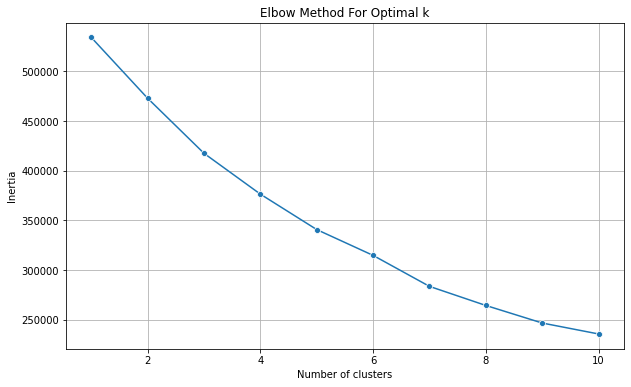

In [9]:
# Using the Elbow Method to find the optimal K
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method Graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [11]:
# Replace 'optimal_k' with the optimal number of clusters you found
optimal_k = 5  # Example: Replace 3 with your found optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(normalized_data)

# Add clusters to the original data
df['Cluster'] = clusters


In [14]:
cluster_summary = df.groupby('Cluster').mean()
cluster_summary['Count'] = df['Cluster'].value_counts()
cluster_summary

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_rate,total_stay_nights,total_guests,Count
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.251414,43.432894,2016.142130,25.885060,15.686571,0.561490,1.691419,1.656109,0.003757,0.0,...,0.236102,25.666290,0.761878,96.856491,0.031391,0.395362,215.123862,2.252909,1.659866,24752
1,0.346243,86.355715,2016.352136,26.959377,16.174700,0.922543,2.372764,1.926331,1.427699,0.0,...,0.287939,13.712061,0.112397,154.393174,0.060198,0.947169,501.833441,3.295306,3.354031,4751
2,0.960908,128.210593,2015.237074,35.810845,16.054224,0.872636,2.282472,1.756620,0.046658,0.0,...,0.097100,13.015132,1.480454,87.900366,0.005044,0.511980,280.437390,3.155107,1.803279,793
3,0.332263,114.857795,2016.392058,27.198743,15.746574,1.217966,2.916233,2.164503,0.002442,0.0,...,0.218056,18.521010,0.713510,119.810895,0.029671,1.002578,479.703870,4.134199,2.166946,22109
4,0.062374,11.966801,2016.309859,24.595573,15.419517,0.372233,1.269618,1.155936,0.017103,0.0,...,0.280684,13.104628,0.094567,64.735332,0.174044,0.873239,112.055241,1.641851,1.173038,994


In [16]:
df

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_rate,total_stay_nights,total_guests,guest_group_type,Cluster
0,0,6,2015,July,27,1,0,2,1,0.0,...,0.00,0,0,Check-Out,2015-07-03,0.00,2,1.0,Solo,0
1,1,88,2015,July,27,1,0,4,2,0.0,...,76.50,0,1,Canceled,2015-07-01,306.00,4,2.0,Couples,3
2,1,65,2015,July,27,1,0,4,1,0.0,...,68.00,0,1,Canceled,2015-04-30,272.00,4,1.0,Solo,0
3,1,92,2015,July,27,1,2,4,2,0.0,...,76.50,0,2,Canceled,2015-06-23,459.00,6,2.0,Couples,3
4,1,100,2015,July,27,2,0,2,2,0.0,...,76.50,0,1,Canceled,2015-04-02,153.00,2,2.0,Couples,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53394,0,23,2017,August,35,30,2,5,2,0.0,...,96.14,0,0,Check-Out,2017-09-06,672.98,7,2.0,Couples,3
53395,0,102,2017,August,35,31,2,5,3,0.0,...,225.43,0,2,Check-Out,2017-09-07,1578.01,7,3.0,Family,3
53396,0,34,2017,August,35,31,2,5,2,0.0,...,157.71,0,3,Check-Out,2017-09-07,1103.97,7,2.0,Couples,3
53397,0,109,2017,August,35,31,2,5,2,0.0,...,104.40,0,0,Check-Out,2017-09-07,730.80,7,2.0,Couples,3


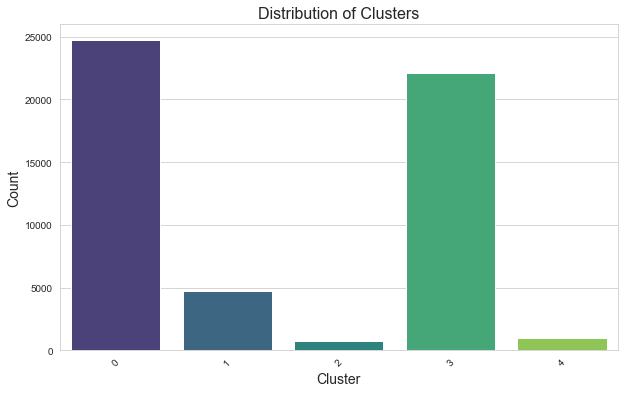

,Cluster,Count
0,0,24752
2,1,4751
4,2,793
1,3,22109
3,4,994


In [18]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of the clusters
cluster_distribution = df['Cluster'].value_counts().reset_index().sort_values(by='index')
cluster_distribution.columns = ['Cluster', 'Count']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Count', data=cluster_distribution, palette='viridis')
plt.title('Distribution of Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Return basic stats
cluster_distribution

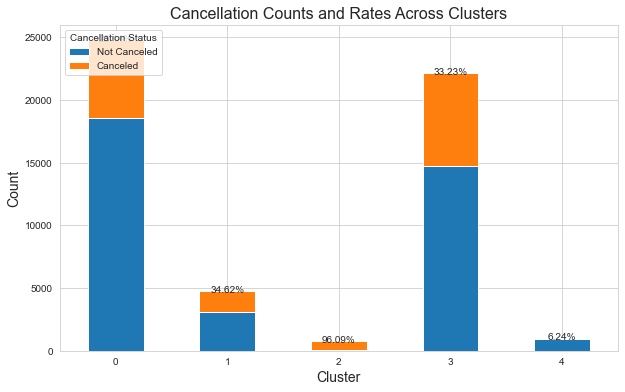

In [24]:
# Calculate the count and cancellation rate for each cluster
cluster_cancellation_count = df.groupby('Cluster')['is_canceled'].value_counts().unstack().fillna(0)
cluster_cancellation_rate = (cluster_cancellation_count[1] / (cluster_cancellation_count[0] + cluster_cancellation_count[1])) * 100

# Create a bar plot
ax = cluster_cancellation_count.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Cancellation Counts and Rates Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Cancellation Status', loc='upper left', labels=['Not Canceled', 'Canceled'])

# Adding text annotations for cancellation rate
for idx, (rect_0, rect_1) in enumerate(zip(ax.patches[:5], ax.patches[5:])):
    height = rect_0.get_height() + rect_1.get_height()
    width = rect_0.get_x() + rect_0.get_width() / 2.
    value = round(cluster_cancellation_rate.iloc[idx], 2)
    ax.text(width, height + 100, f'{value}%', ha='center', va='center', fontsize=10)

plt.show()


ValueError: Could not interpret input 'country'

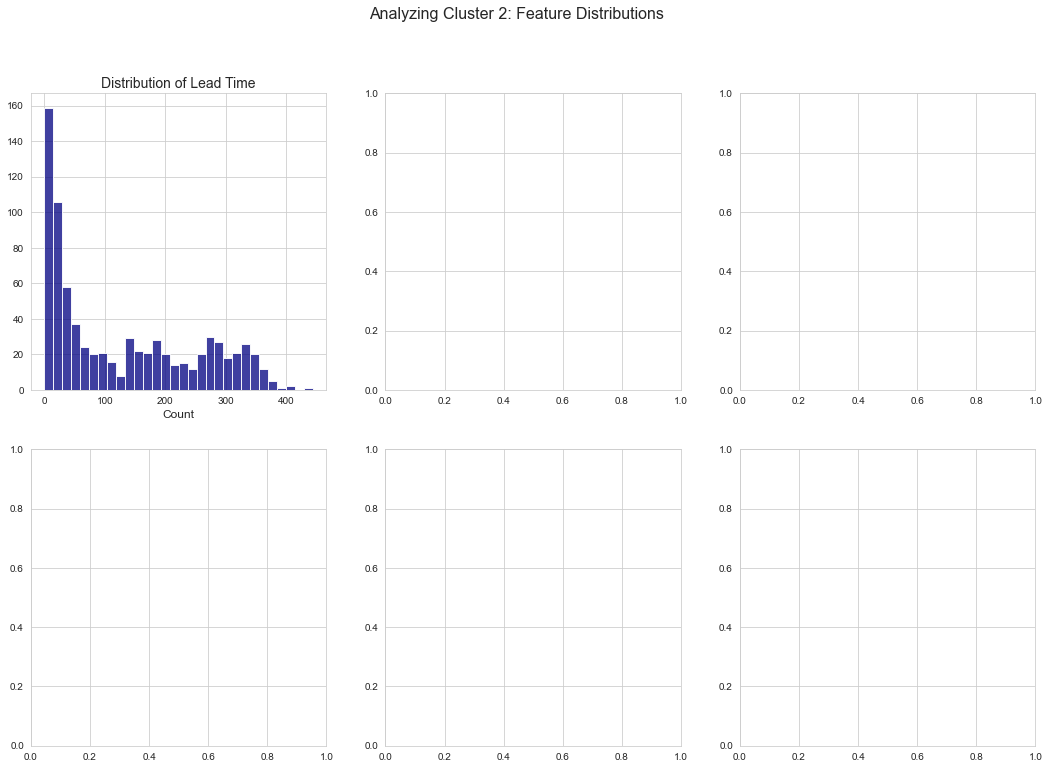

In [26]:
# Extracting Cluster 2 data
cluster_2 = df[df['Cluster'] == 2]

# Selecting features to explore
features_to_explore = ['lead_time', 'country', 'market_segment', 'previous_cancellations', 
                        'total_of_special_requests', 'customer_type']

# Creating subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Analyzing Cluster 2: Feature Distributions', fontsize=16)

# Reshaping the axes for easy iteration
axes = axes.ravel()

# Plotting distributions for each selected feature
for i, feature in enumerate(features_to_explore):
    # Plotting categorical features
    if df[feature].dtype == 'object':
        sns.countplot(y=feature, df=cluster_2, order=cluster_2[feature].value_counts().index, ax=axes[i], palette='viridis')
    # Plotting numerical features
    else:
        sns.histplot(cluster_2[feature], bins=30, kde=False, ax=axes[i], color='navy')
    
    # Title and labels
    axes[i].set_title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=14)
    axes[i].set_xlabel('Count', fontsize=12)
    axes[i].set_ylabel('')

# Adjusting layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Displaying top countries and market segments in Cluster 2
top_countries_cluster_2 = cluster_2['country'].value_counts().head(5)
top_market_segments_cluster_2 = cluster_2['market_segment'].value_counts().head(5)

(top_countries_cluster_2, top_market_segments_cluster_2)
